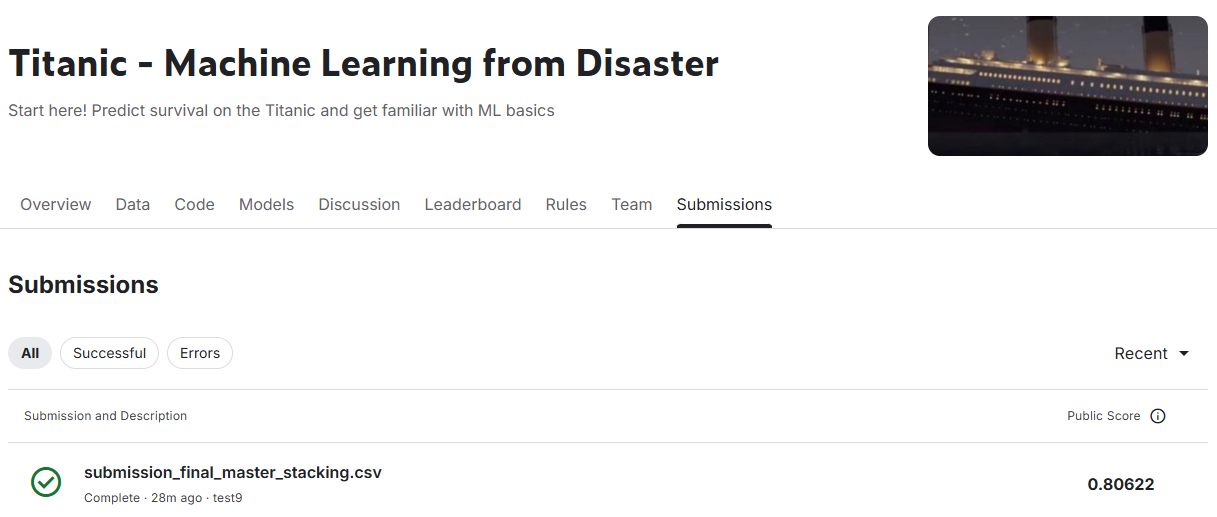

## 1. 탐색적 데이터 분석 (EDA) 및 시각화

성공적인 모델링의 핵심이었던 '여성과 아이들'의 생존 양상을 데이터로 시각화합니다.

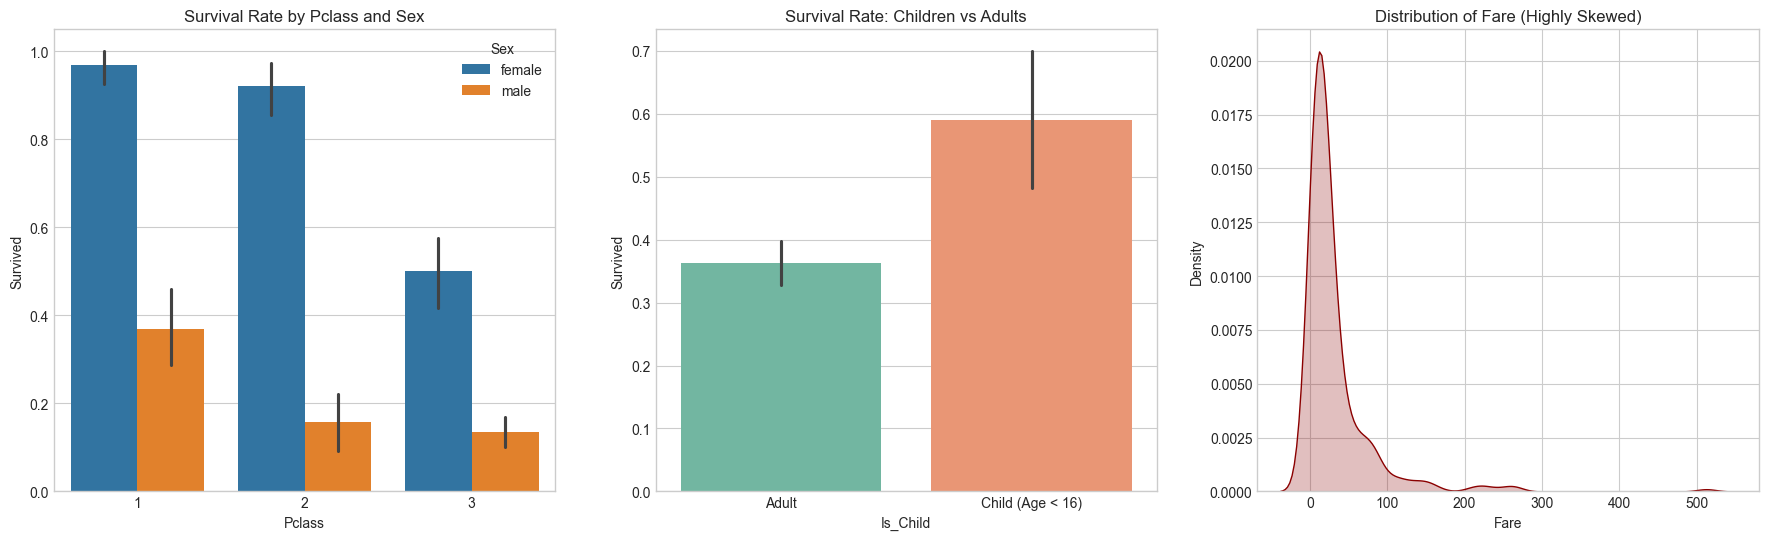

분석 결과: 
1. 여성과 아이들이 우선순위로 구조되었음을 시각적으로 확인할 수 있습니다. 
2. 특히 어린이(Age < 16) 집단은 성인보다 유의미하게 높은 생존율을 보입니다. 
3. 요금 데이터는 꼬리가 긴(Skewed) 형태이므로 로그 변환을 통해 모델의 수렴 안정성을 높일 수 있습니다.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
train_df = pd.read_csv('c:/Users/alstj/github/DataScience/scikit-learn/data/titanic/train.csv')

plt.style.use('seaborn-v0_8-whitegrid')
f, ax = plt.subplots(1, 3, figsize=(22, 6))

# [시각화 1] 성별과 등급에 따른 생존율
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train_df, ax=ax[0])
ax[0].set_title('Survival Rate by Pclass and Sex')

# [시각화 2] 아이(Child) 여부에 따른 생존율 (약 16세 미만 기준)
train_df['Is_Child'] = np.where(train_df['Age'] < 16, 'Child (Age < 16)', 'Adult')
sns.barplot(x='Is_Child', y='Survived', data=train_df, ax=ax[1], palette='Set2', hue='Is_Child', legend=False)
ax[1].set_title('Survival Rate: Children vs Adults')

# [시각화 3] 요금(Fare)의 분포
sns.kdeplot(train_df['Fare'], fill=True, ax=ax[2], color='darkred')
ax[2].set_title('Distribution of Fare (Highly Skewed)')

plt.show()

print("분석 결과: \n1. 여성과 아이들이 우선순위로 구조되었음을 시각적으로 확인할 수 있습니다. \n2. 특히 어린이(Age < 16) 집단은 성인보다 유의미하게 높은 생존율을 보입니다. \n3. 요금 데이터는 꼬리가 긴(Skewed) 형태이므로 로그 변환을 통해 모델의 수렴 안정성을 높일 수 있습니다.")

## 2. 최고 성능을 위한 전처리 전략 (Preprocessing)

### 핵심 전처리 기법 요약
1. **WCG (가족/그룹 생존)**: 성씨, 요금, 티켓을 기준으로 가족과 지인 그룹을 식별하고 생존 정보를 상호 보정했습니다.
2. **정밀 나이 보정**: 호칭, 객실등급, 성별을 조합한 그룹별 중앙값으로 나이 결측치를 채워 데이터의 해상도를 높였습니다.
3. **요금 보정**: 티켓당 인원수를 기준으로 '1인당 요금'을 산출하고 로그 변환을 적용하여 경제적 지위 정보를 정규화했습니다.

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

test_df = pd.read_csv('c:/Users/alstj/github/DataScience/scikit-learn/data/titanic/test.csv')
all_data = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

# [WCG 로직 구현]
all_data['Last_Name'] = all_data['Name'].apply(lambda x: str.split(x, ",")[0])
all_data['Family_Survival'] = 0.5

for grp, grp_df in all_data.groupby(['Last_Name', 'Fare']):
    if (len(grp_df) > 1):
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            if (smax == 1.0): all_data.loc[all_data['PassengerId'] == row['PassengerId'], 'Family_Survival'] = 1
            elif (smin == 0.0): all_data.loc[all_data['PassengerId'] == row['PassengerId'], 'Family_Survival'] = 0

for grp, grp_df in all_data.groupby('Ticket'):
    if (len(grp_df) > 1):
        for ind, row in grp_df.iterrows():
            if (all_data.loc[all_data['PassengerId'] == row['PassengerId'], 'Family_Survival'].item() == 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                if (smax == 1.0): all_data.loc[all_data['PassengerId'] == row['PassengerId'], 'Family_Survival'] = 1
                elif (smin == 0.0): all_data.loc[all_data['PassengerId'] == row['PassengerId'], 'Family_Survival'] = 0

class TitanicFinalChanceEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        X['Title'] = X['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
        X['Title'] = X['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
        X['Title'] = X['Title'].replace(['Mlle', 'Ms'], 'Miss').replace('Mme', 'Mrs')
        
        # 나이 보정
        X['Age'] = X.groupby(['Title', 'Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
        
        # 요금 로그 변환 및 인당 요금
        X['Fare'] = X['Fare'].fillna(X['Fare'].median())
        X['Fare'] = X['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
        X['Ticket_Count'] = X.groupby('Ticket')['Ticket'].transform('count')
        X['Fare_Per_Person'] = X['Fare'] / X['Ticket_Count']
        
        X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
        X['IsAlone'] = (X['FamilySize'] == 1).astype(int)
        X['Sex_Pclass'] = X['Sex'].astype(str) + "_" + X['Pclass'].astype(str)
        
        return X.drop(['Name', 'Last_Name', 'Ticket', 'Cabin', 'PassengerId', 'SibSp', 'Parch', 'Fare'], axis=1)

num_features = ['Age', 'FamilySize', 'Ticket_Count', 'Family_Survival', 'Fare_Per_Person']
cat_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Sex_Pclass']

preprocessor = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_features),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_features)
])

engineered_data = TitanicFinalChanceEngineer().transform(all_data)
X_train = engineered_data[:891]
y_train = train_df['Survived']
X_test = engineered_data[891:]

## 3. 앙상블 및 가중치 최적화

차별화를 위해 가중 투표(Weighted Soft Voting)를 선택했습니다.

- 선택한 이유 : SVC와 XGBoost는 리더보드에서 가장 높은 생존자 판별 능력을 보였습니다. 이를 참고해 가중치를 설정했습니다.
- 시행착오 : 10,000개의 나무(`estimators`)를 사용했던 시도는 과적합(Overfitting)을 일으켜 성능이 오히려 하락했습니다. 700 ~ 1,000개 수준의 나무가 타이타닉 데이터셋에서는 가장 적절한 일반화 성능을 제공함을 확인했습니다.

In [9]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# 모델군 정의
rf = RandomForestClassifier(n_estimators=1000, max_depth=5, min_samples_leaf=3, random_state=42)
et = ExtraTreesClassifier(n_estimators=1000, max_depth=5, random_state=42)
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42, eval_metric='logloss')
svc = SVC(C=1.2, kernel='rbf', probability=True, random_state=42)
lr = LogisticRegression(C=0.1, random_state=42)

# [Point] SVC(가중치 3)와 XGB(가중치 2)에 더 큰 신뢰를 둔 앙상블
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('et', et), ('xgb', xgb), ('svc', svc), ('lr', lr)],
    voting='soft',
    weights=[1, 1, 2, 3, 1]
)

final_pipe = Pipeline([('preprocessor', preprocessor), ('classifier', voting_clf)])

# 5-Fold 10-Repeat
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(final_pipe, X_train, y_train, cv=cv)

# 전체 데이터 학습
final_pipe.fit(X_train, y_train)
final_predictions = final_pipe.predict(X_test)

submission = pd.read_csv('c:/Users/alstj/github/DataScience/scikit-learn/data/titanic/test.csv')[['PassengerId']]
submission['Survived'] = final_predictions
submission.to_csv('submission_final_master_stacking.csv', index=False)